In [4]:
import cv2
import colour
from PIL import Image
import numpy as np
import time
import os, sys

print(np.__version__)
print(cv2.__version__)
print(colour.__version__)

1.24.3
4.7.0
0.4.2


In [5]:
def plot_rgbl(img_rgbl, box_size = (25, 25)):
    nb_boxes = img_rgbl.shape[0]
    
    if len(img_rgbl.shape) == 3:
        clrs = np.ascontiguousarray(np.tile(img_rgbl[:, 0, 0:3].reshape(nb_boxes, 3, 1, 1), (box_size[0], box_size[1])).transpose(0, 2, 3, 1))
    elif len(img_rgbl.shape) == 2:
        clrs = np.ascontiguousarray(np.tile(img_rgbl[:, 0:3].reshape(nb_boxes, 3, 1, 1), (box_size[0], box_size[1])).transpose(0, 2, 3, 1))
    else:
        raise ValueError
    
    clrs.resize((nb_boxes*box_size[0], box_size[1], 3))
    clrs = clrs.transpose(1, 0, 2)
    clrs = np.clip(clrs * 255, 0, 255).astype('uint8')
    return clrs

In [6]:
def crop_center(image, crop_width, crop_height):
    width, height = image.size
    
    # トリミングする領域の左上の座標を計算
    # left = int((width - crop_width) / 2)
    left = int((width - crop_width) / 2 - 50)
    # top = int((height - crop_height) / 2)
    top = int((height - crop_height) / 2 - 50)
    
    # 画像をトリミング
    cropped_image = image.crop((left, top, left + crop_width, top + crop_height))
    
    return cropped_image

In [7]:
def rgb_to_lab(rgb_normalized):
    # RGB の値を 0-1 の範囲に正規化
    # rgb_normalized = [channel / 255.0 for channel in rgb]
    
    # RGB を XYZ に変換
    xyz = colour.sRGB_to_XYZ(rgb_normalized)
    
    # XYZ を Lab に変換
    lab = colour.XYZ_to_Lab(xyz)
    
    return lab

In [13]:
FILE_PATH = os.path.join('/', 'Users', 'ats', 'hobbies', 'jupyerlab', 'camera', 'images')
ILUMINATIONS = ['daylightLow', ]
DEVICES = ['gopro', 'imx',]
IMGS = {}
# IMG_SIZE = (1020, 816)
IMG_SIZE = (1000, 750)
GOPRO_FILE_NAME = 'gopro_isp_202306201633.jpg'
IMX_FILE_NAME = 'imx477_isp_202306201633.jpg'

## Load image

In [17]:
for ilumination in ILUMINATIONS:
    IMGS[ilumination] = {}
    for device in DEVICES:
        if device == 'gopro':
            filepath = os.path.join(FILE_PATH, GOPRO_FILE_NAME)
            print(filepath)
            assert os.path.isfile(filepath)
            img = Image.open(filepath).rotate(270) # Rotate to position the WHITE on the bottom left corner
            IMGS[ilumination][device] = crop_center(img, IMG_SIZE[0], IMG_SIZE[1])
        else:
            filepath = os.path.join(FILE_PATH, IMX_FILE_NAME)
            print(filepath)
            assert os.path.isfile(filepath)
            # img = Image.open(filepath).rotate(180) # Rotate to position the WHITE on the bottom left corner
            img = Image.open(filepath).rotate(170) # Rotate to position the WHITE on the bottom left corner
            IMGS[ilumination][device] = crop_center(img, IMG_SIZE[0], IMG_SIZE[1])

/Users/ats/hobbies/jupyerlab/camera/images/gopro_isp_202306201633.jpg
/Users/ats/hobbies/jupyerlab/camera/images/imx477_isp_202306201633.jpg


In [18]:
print(IMGS)

{'daylightLow': {'gopro': <PIL.Image.Image image mode=RGB size=1000x750 at 0x1482A8050>, 'imx': <PIL.Image.Image image mode=RGB size=1000x750 at 0x148218450>}}


daylightLow


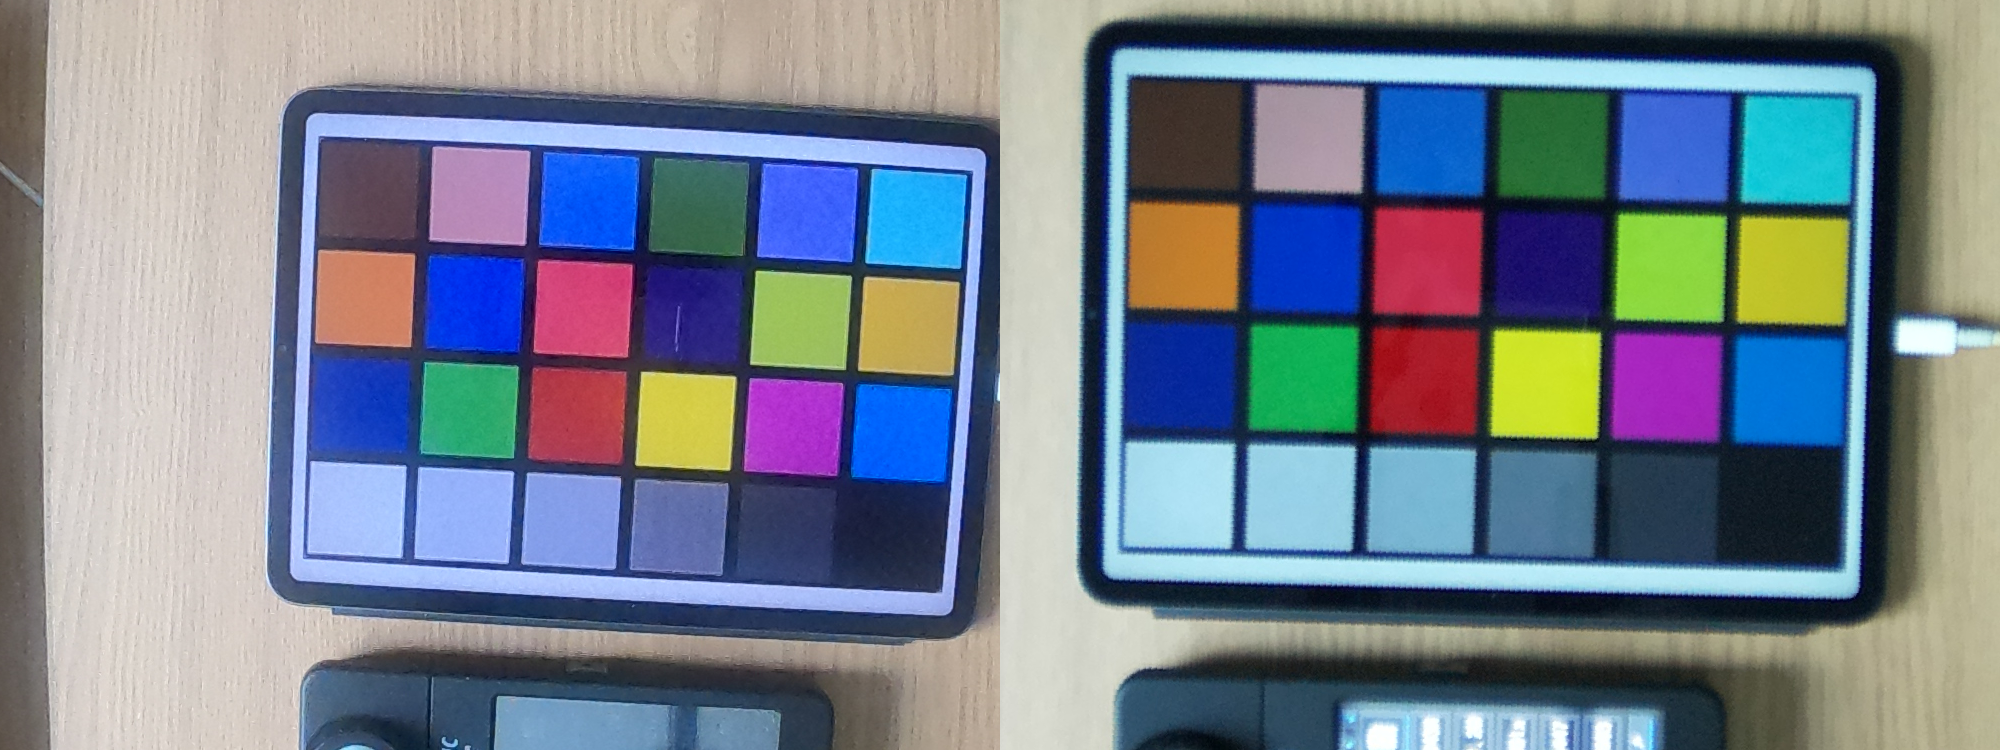

In [19]:
for ilumination in ILUMINATIONS:
    print(ilumination)
    comp_img = np.zeros((IMG_SIZE[1], IMG_SIZE[0]*len(DEVICES), 3), 'uint8')
    for i, device in enumerate(DEVICES):
        img = np.array(IMGS[ilumination][device])
        comp_img[:, IMG_SIZE[0]*i:IMG_SIZE[0]*(i+1), :] = img
    display(Image.fromarray(comp_img))

## Detect Color Card

daylightLow


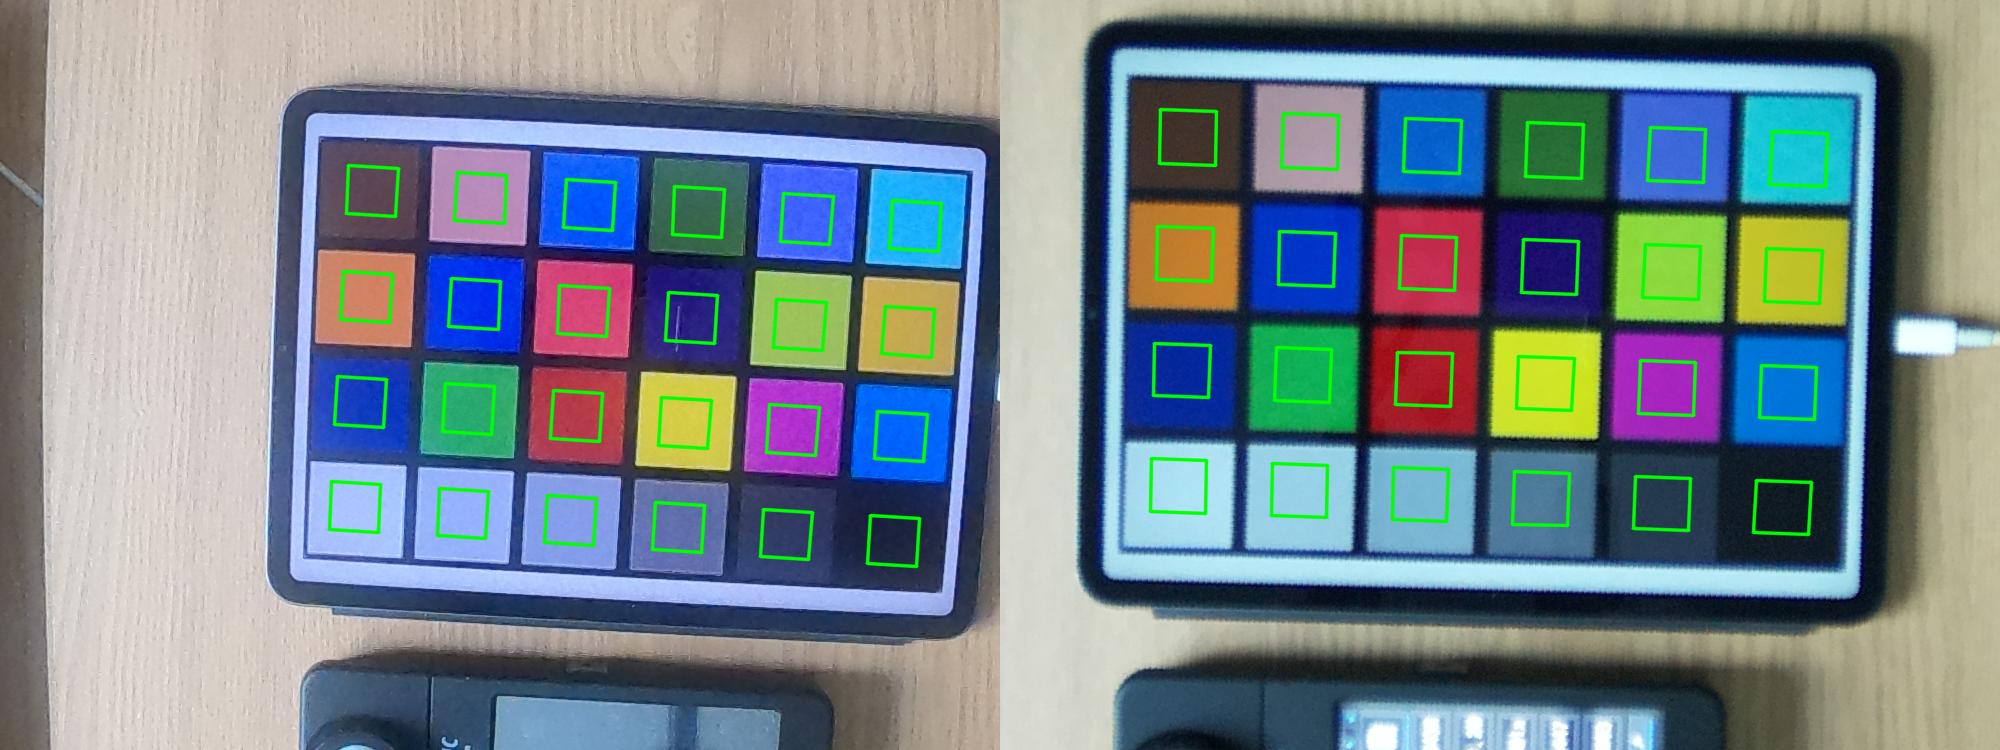

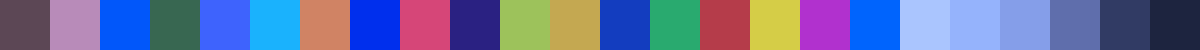

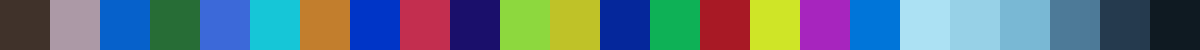

In [20]:
CHARTS = {}
CHECKER_SRCS = {}
for ilumination in ILUMINATIONS:
    CHARTS[ilumination] = {}
    CHECKER_SRCS[ilumination] = {}
    print(ilumination)
    comp_img = np.zeros((IMG_SIZE[1], IMG_SIZE[0]*len(DEVICES), 3), 'uint8')
    srcs = []
    for i, device in enumerate(DEVICES):
        img = np.array(IMGS[ilumination][device]).copy()
        
        # Detect Color CHart and extract checker
        detector = cv2.mcc.CCheckerDetector_create()
        succ = detector.process(img, chartType=cv2.mcc.MCC24, nc=1, useNet=True)
        assert succ
        checker = detector.getBestColorChecker()
        CHARTS[ilumination][device] = checker
        
        # Process checker to extract colors
        chartsRGB = checker.getChartsRGB()
        src_rgb = chartsRGB[:, 1].copy()
    
        # Bottom left corner is assumed to be WHITE
        src_rgb = np.round(src_rgb, 0).astype('uint8')
        src_rgb.resize(24, 3)
        src_rgb = src_rgb[::-1, ::-1]
        src = (src_rgb.copy()/255)[:, np.newaxis, :]
        
        # Check direction
        if src[0].mean() < src[-1].mean():
            src = src[::-1]
        CHECKER_SRCS[ilumination][device] = src
        
        # Keep to plat later
        srcs.append(src)
        
        # Draw
        draw = cv2.mcc.CCheckerDraw_create(checker, color=(0, 255, 0), thickness=2)
        draw.draw(img)
        
        comp_img[:, IMG_SIZE[0]*i:IMG_SIZE[0]*(i+1), :] = img
    display(Image.fromarray(comp_img))
    
    # Plot colors
    for src in srcs:
        display(Image.fromarray(plot_rgbl(src.copy(), (50, 50))))

## Caluclate the defference between two colorchats

In [21]:
GOPRO_INDEX = 0
IMX_INDEX = 1

normalized_rgbs = np.array(srcs)
rows = len(normalized_rgbs)
columns = len(normalized_rgbs[GOPRO_INDEX])

assert rows == 2
assert columns == 24

# https://www.imatest.com/docs/colorcheck
labels = [
    'dark skin', 'light skin', 'blue sky', 'foliage', 'blue flower', 'bluish green',
    'orange', 'purplish blue', 'moderate red', 'purple', 'yellow green', 'orange yellow',
    'blue', 'green', 'red', 'yellow', 'magenta', 'cyan',
    'white', 'neutral 8', 'neutral 6.5', 'neutral 5', 'neutral 3.5', 'black'
]
diffs = np.empty(columns)
for j in range(columns):
    target_lab = rgb_to_lab(normalized_rgbs[GOPRO_INDEX][j])
    tuned_lab = rgb_to_lab(normalized_rgbs[IMX_INDEX][j])
    diff = np.sqrt(((target_lab - tuned_lab) ** 2).sum())

    print(f'{labels[j]}: {diff}')
    diffs[j] = diff

print(f'Total: {diffs.sum()}')

dark skin: 17.67879147860677
light skin: 20.533124438613218
blue sky: 34.754749114014174
foliage: 21.320940205240362
blue flower: 24.861426305501148
bluish green: 36.110880615629725
orange: 24.509282955815948
purplish blue: 23.16493233223046
moderate red: 15.941647370184151
purple: 7.854381041221946
yellow green: 25.796494172165357
orange yellow: 29.034928293068006
blue: 11.207645394043146
green: 18.008912003919196
red: 16.07691936611207
yellow: 22.466749251495404
magenta: 5.041639129384643
cyan: 34.149957211833765
white: 24.751422063208526
neutral 8: 31.769719761769718
neutral 6.5: 31.258028045555776
neutral 5: 22.799215975851496
neutral 3.5: 15.108019517588325
black: 15.050624424408152
Total: 529.2504304674615


In [468]:
print("\t".join(str(num) for num in diffs))

15.9880674527	15.0103919855	4.86036003064	18.8134349237	6.74452831825	13.5864070693	18.5216121414	6.73493899765	11.8757908053	9.53823101087	16.1669467314	21.4919280694	16.7866989996	4.85648038413	20.4369507276	13.5415990387	5.62679982582	21.5101861442	15.4579083336	16.3323432488	23.7887161696	20.6767594465	14.1364758158	7.84832254709


## Caluclate color matrix

In [456]:
BLUE_COLOR_CHART_INDEX = 12
GREEN_COLOR_CHART_INDEX = 13
RED_COLOR_CHART_INDEX = 14

target_blue = normalized_rgbs[GOPRO_INDEX][BLUE_COLOR_CHART_INDEX][0]
target_green = normalized_rgbs[GOPRO_INDEX][GREEN_COLOR_CHART_INDEX][0]
target_red = normalized_rgbs[GOPRO_INDEX][RED_COLOR_CHART_INDEX][0]
target = np.array([target_blue, target_green, target_red]) * 255

tuned_blue = normalized_rgbs[IMX_INDEX][BLUE_COLOR_CHART_INDEX][0]
tuned_green = normalized_rgbs[IMX_INDEX][GREEN_COLOR_CHART_INDEX][0]
tuned_red = normalized_rgbs[IMX_INDEX][RED_COLOR_CHART_INDEX][0]
tuned = np.array([tuned_blue, tuned_green, tuned_red]) * 255

print('target', target)
print('tuned', tuned)

# # 最小二乗法を用いてXを計算
# color_correction_matrix, _, _, _ = np.linalg.lstsq(tuned, target, rcond=None)

# # 各行の合計を計算
# row_sums = np.sum(color_correction_matrix, axis=1)

# # 各要素を行の合計で割って正規化
# normalized_matrix = color_correction_matrix / row_sums[:, np.newaxis]

# print(normalized_matrix)

# print(target * normalized_matrix)

tuned_inv = np.linalg.inv(tuned)

X = np.dot(tuned_inv, target)
print(X)
print(np.dot(X, tuned))

target [[   2.   37.  147.]
 [   1.  116.   57.]
 [ 113.   21.   35.]]
tuned [[ 109.  197.   91.]
 [  43.   50.  134.]
 [ 176.   59.  111.]]
[[ 0.85015231 -0.53564291 -0.18132427]
 [-0.40798602  0.00593325  0.75292477]
 [-0.11311379  1.03534315  0.2026172 ]]
[[  37.72088585  129.99972769  -14.53928302]
 [  88.29941265  -35.65402271   47.24297663]
 [  67.85097967   41.43815556  150.93313686]]


In [293]:
color_correction_matrix = np.array([
    [1.75082, -0.730458, -0.0203626],
    [0.00246214, 1.05709, -0.0595569,],
    [0.110314, -0.596619, 1.4863]
])

new_color_correction_matrix = np.dot(X, color_correction_matrix)

# 各行の合計を計算
row_sums = np.sum(new_color_correction_matrix, axis=1)

# 各要素を行の合計で割って正規化
normalized_matrix = new_color_correction_matrix / row_sums[:, np.newaxis]

print(normalized_matrix)

[[ 1.62416641 -0.60022917 -0.02393724]
 [ 0.23078305  0.51692501  0.25229195]
 [ 0.2552963  -0.58562894  1.33033264]]
